This file contains python code to check the hypothesis testing

In [4]:
import sys
sys.path.append("../../mypkg")

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [6]:
import importlib
import models.linear_model 
importlib.reload(models.linear_model)

<module 'models.linear_model' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/test_bak_notebooks/../../mypkg/models/linear_model.py'>

In [7]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs#, gen_simu_psd
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization

from penalties.scad_pen import SCAD
from models.linear_model import LinearModel


In [8]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and fns

### Params

In [9]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 0 # the sd of the noise added to the true value for initial values
paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
#paras.SIS_ratio = 0.4 # the ratio to keep with SIS procedure

# generating dataset
paras.n = 20000 # num of data obs to be genareted
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 5 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 12 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
#paras.fourier_basis_coefs = ([coef_fn(0.1), coef_fn(0.3), coef_fn(0.5)] + 
#                             [np.zeros(50)] * (paras.d-3-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
                             [coef_fn(0.7), coef_fn(0.9)]
                             )
#paras.fourier_basis_coefs = ([np.zeros(50)] * paras.d)
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
#
paras.Gam_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(3, paras.d) # M^c set, 
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
paras.Rfct = 2
paras.stop_cv = 5e-4
paras.max_iter = 2000

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


The number of B-spline basis is 12.


In [145]:
paras.save_dir = RES_ROOT/"linear_test"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

### Fns

In [146]:

def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [147]:
def get_Amat(k, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        paras: parameters
                required: N, Cmat, m, q
    """
    _paras = edict(paras.copy())
    
    part1 = np.kron(_paras.Cmat, np.eye(_paras.N))
    part2 = np.zeros((_paras.m*_paras.N, _paras.q+(_paras.m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+_paras.m*_paras.N)] = np.eye(_paras.m*_paras.N)
    A = part1 @ part2
    return A

In [148]:
def _gen_simu_data_all(seed, paras):
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    
    #simu_psd = gen_simu_psd(_paras.n, _paras.d, 10, 2)
    simu_psd = np.random.randn(_paras.n, _paras.d, 40)*10
    #simu_psd = std_real_psd[:, :_paras.d]
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_psd[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.tensor(simu_psd) # n x d x npts
    Z = torch.tensor(simu_covs) # n x q
    Y = torch.tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data

## Simu

In [183]:
seed = 0
T_vs = []
T_p1s = []
Psis = []
nonzero_idxss = []
for seed in trange(1000):

    _paras = edict(paras.copy())
    _paras.seed = seed
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
        
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    model._linear_term_der()
    Xt = model.lin_tm_der # Mx(q+dN)
    est_theta = svd_inverse(Xt.T @ Xt + 0*torch.eye(Xt.shape[-1]), 0.99)@Xt.T@cur_data_SIS.Y
    ##est_theta = torch.inverse(Xt.T @ Xt)@Xt.T@Y
    #
    est_alp = est_theta[:_paras.q]
    est_Gam = col_vec2mat_fn(est_theta[_paras.q:], nrow=_paras.N)*np.sqrt(_paras.N)
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
        
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.tensor(get_Amat(k, _paras))
        
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    Q_mat_part_inv = svd_inverse(Q_mat_part, 0.99)
        
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
        
    T_p1 = Amat @ est_theta[keep_idxs_test]
    Psi_inv = svd_inverse(Psi, 0.99)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    print(T_v)

    Psis.append(Psi)
    T_p1s.append(T_p1)
    T_vs.append(T_v.item())
    nonzero_idxss.append(nonzero_idxs)

  0%|▏                                                                                                                                        | 1/1000 [00:01<19:36,  1.18s/it]

tensor(71.6576)


  0%|▎                                                                                                                                        | 2/1000 [00:01<13:17,  1.25it/s]

tensor(29.1102)


  0%|▍                                                                                                                                        | 3/1000 [00:02<11:07,  1.49it/s]

tensor(27.2860)


  0%|▌                                                                                                                                        | 4/1000 [00:02<10:03,  1.65it/s]

tensor(35.1902)


  0%|▋                                                                                                                                        | 5/1000 [00:03<09:29,  1.75it/s]

tensor(44.3452)


  1%|▊                                                                                                                                        | 6/1000 [00:03<09:07,  1.81it/s]

tensor(36.8369)


  1%|▉                                                                                                                                        | 7/1000 [00:04<08:53,  1.86it/s]

tensor(40.3960)


  1%|█                                                                                                                                        | 8/1000 [00:04<08:45,  1.89it/s]

tensor(24.4370)


  1%|█▏                                                                                                                                       | 9/1000 [00:05<08:38,  1.91it/s]

tensor(79.5390)


  1%|█▎                                                                                                                                      | 10/1000 [00:05<08:36,  1.92it/s]

tensor(32.6244)


  1%|█▍                                                                                                                                      | 11/1000 [00:06<08:31,  1.93it/s]

tensor(40.1421)


  1%|█▋                                                                                                                                      | 12/1000 [00:06<08:27,  1.95it/s]

tensor(26.9736)


  1%|█▊                                                                                                                                      | 13/1000 [00:07<08:25,  1.95it/s]

tensor(35.4952)


  1%|█▉                                                                                                                                      | 14/1000 [00:07<08:22,  1.96it/s]

tensor(40.0173)


  2%|██                                                                                                                                      | 15/1000 [00:08<08:23,  1.95it/s]

tensor(32.7874)


  2%|██▏                                                                                                                                     | 16/1000 [00:08<08:22,  1.96it/s]

tensor(36.5808)


  2%|██▎                                                                                                                                     | 17/1000 [00:09<08:23,  1.95it/s]

tensor(22.9050)


  2%|██▍                                                                                                                                     | 18/1000 [00:09<08:22,  1.95it/s]

tensor(39.2528)


  2%|██▌                                                                                                                                     | 19/1000 [00:10<08:22,  1.95it/s]

tensor(33.4062)


  2%|██▋                                                                                                                                     | 20/1000 [00:10<08:20,  1.96it/s]

tensor(30.7709)


  2%|██▊                                                                                                                                     | 21/1000 [00:11<08:19,  1.96it/s]

tensor(32.4409)


  2%|██▉                                                                                                                                     | 22/1000 [00:11<08:27,  1.93it/s]

tensor(23.3158)


  2%|███▏                                                                                                                                    | 23/1000 [00:12<08:26,  1.93it/s]

tensor(59.3835)


  2%|███▎                                                                                                                                    | 24/1000 [00:12<08:24,  1.93it/s]

tensor(33.3636)


  2%|███▍                                                                                                                                    | 25/1000 [00:13<08:20,  1.95it/s]

tensor(36.0577)


  3%|███▌                                                                                                                                    | 26/1000 [00:13<08:18,  1.95it/s]

tensor(43.7949)


  3%|███▋                                                                                                                                    | 27/1000 [00:14<08:18,  1.95it/s]

tensor(39.9406)


  3%|███▊                                                                                                                                    | 28/1000 [00:15<08:17,  1.95it/s]

tensor(29.5283)


  3%|███▉                                                                                                                                    | 29/1000 [00:15<08:16,  1.96it/s]

tensor(39.3894)


  3%|████                                                                                                                                    | 30/1000 [00:16<08:17,  1.95it/s]

tensor(32.0480)


  3%|████▏                                                                                                                                   | 31/1000 [00:16<08:41,  1.86it/s]

tensor(47.6665)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_55898/2978364134.py", line 30, in <module>
    model._linear_term_der()
  File "/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/models/base_model.py", line 47, in _linear_term_der
    vec_part2_raw = basis_mat_trans*X_trans
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1101,

TypeError: object of type 'NoneType' has no len()

In [150]:
keep_idxs_test.shape

(65,)

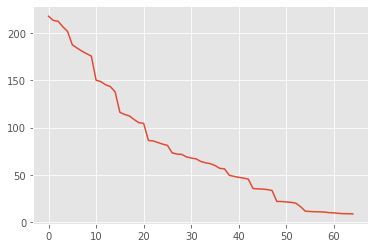

In [151]:
Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0)
plt.plot(torch.svd(Sig_mat).S)

In [152]:
est_alp

tensor([ 4.9752,  0.9538, -2.0075,  2.9834, -3.9781])

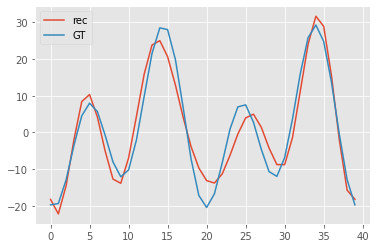

In [153]:
rec_curs = paras.basis_mat @ est_Gam
idx = -1
plt.plot(rec_curs[:, idx], label="rec")
plt.plot(paras.beta_GT[:, idx], label="GT")
plt.legend()

In [154]:
torch.norm(est_Gam, dim=0)

tensor([  0.7878,   1.1837,   1.3587,  86.2405, 129.9280])

In [155]:
np.linalg.norm(_paras.Gam_est, axis=0)

array([  0.        ,   0.        ,   0.        ,  85.8916734 ,
       130.01118172])

<AxesSubplot:>

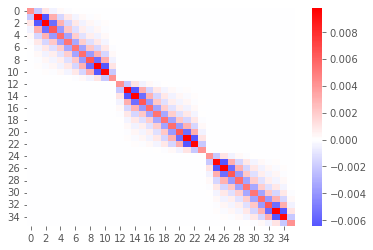

In [156]:
tmp1 = np.mean([ix.numpy() for ix in Psis], axis=0)/paras.n
sns.heatmap(tmp1, center=0, cmap="bwr")

<AxesSubplot:>

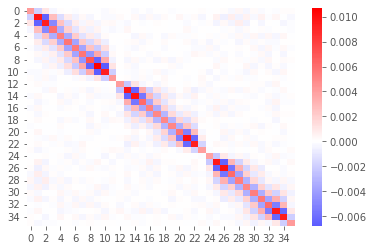

In [157]:
tmp2 = np.cov(np.array([ix.numpy() for ix in T_p1s]).T)
sns.heatmap(tmp2, center=0, cmap="bwr")

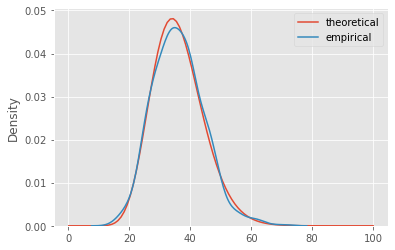

In [179]:
from scipy.stats import chi2
chi_df = paras.r*paras.N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(np.array(T_vs), label="empirical")
plt.legend()

In [180]:
CV = chi2.ppf(0.95, chi_df)
np.mean(np.array(T_vs)>CV)

0.037

In [181]:
np.mean(T_vs)

36.004146853807136